## Parte1

In [1]:
# Import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder

# Algoritmi
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

### Punto 1.1

In [2]:
path = 'new_weather.csv'
dataset = pd.read_csv(path, sep = ',')
dataset.head()

,Date,Max_Temperature_F,Mean_Temperature_F,Min_TemperatureF,Max_Dew_Point_F,MeanDew_Point_F,Min_Dewpoint_F,Max_Humidity,Mean_Humidity,Min_Humidity,...,Min_Sea_Level_Pressure_In,Max_Visibility_Miles,Mean_Visibility_Miles,Min_Visibility_Miles,Max_Wind_Speed_MPH,Mean_Wind_Speed_MPH,Events,Month,Year,Day
0,2014-10-13,71,62.0,54,55,51,46,87,68,46,...,29.65,10,10,4,13,4,Rain,10.0,2014.0,13.0
1,2014-10-14,63,59.0,55,52,51,50,88,78,63,...,29.54,10,9,3,10,5,Rain,10.0,2014.0,14.0
2,2014-10-15,62,58.0,54,53,50,46,87,77,67,...,29.51,10,9,3,18,7,Rain,10.0,2014.0,15.0
3,2014-10-16,71,61.0,52,49,46,42,83,61,36,...,29.81,10,10,10,9,4,Rain,10.0,2014.0,16.0
4,2014-10-17,64,60.0,57,55,51,41,87,72,46,...,29.73,10,10,6,8,3,Rain,10.0,2014.0,17.0


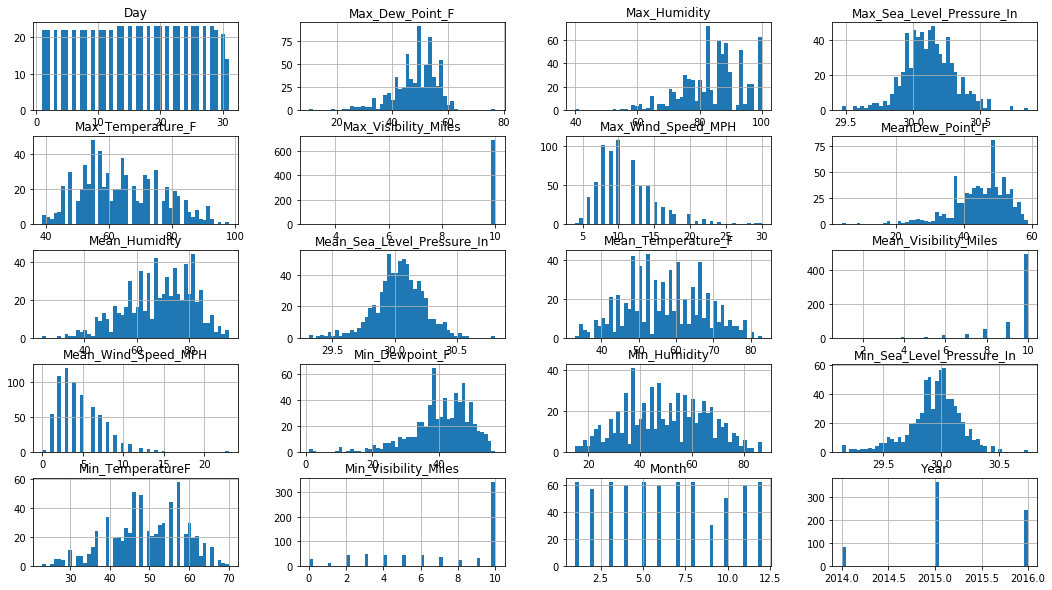

In [3]:
# Visualizzo distribuzioni valori
dataset.hist(figsize = (18, 10), bins = 50)
plt.show()

In [4]:
# Visualizzo corrispondenza tra i valori
dataset.corr()

,Max_Temperature_F,Mean_Temperature_F,Min_TemperatureF,Max_Dew_Point_F,MeanDew_Point_F,Min_Dewpoint_F,Max_Humidity,Mean_Humidity,Min_Humidity,Max_Sea_Level_Pressure_In,Mean_Sea_Level_Pressure_In,Min_Sea_Level_Pressure_In,Max_Visibility_Miles,Mean_Visibility_Miles,Min_Visibility_Miles,Max_Wind_Speed_MPH,Mean_Wind_Speed_MPH,Month,Year,Day
Max_Temperature_F,1.000000,0.970604,0.850757,0.728071,0.716776,0.618153,-0.538677,-0.673360,-0.645518,-0.245586,-0.113305,-0.004340,0.076832,0.352930,0.433822,-0.078493,-0.104616,0.070649,0.183084,-0.001014
Mean_Temperature_F,0.970604,1.000000,0.950002,0.804748,0.813847,0.736988,-0.521249,-0.584973,-0.521134,-0.304912,-0.174619,-0.063535,0.082847,0.322032,0.377079,-0.026462,-0.018131,0.103150,0.158193,0.005165
Min_TemperatureF,0.850757,0.950002,1.000000,0.835920,0.871332,0.830241,-0.453532,-0.417029,-0.310985,-0.360273,-0.241918,-0.136873,0.078531,0.247176,0.266639,0.038953,0.094826,0.131116,0.111471,0.015022
Max_Dew_Point_F,0.728071,0.804748,0.835920,1.000000,0.963160,0.858492,-0.041315,-0.067954,-0.044160,-0.381999,-0.303180,-0.223668,0.074115,0.084930,0.023170,0.153649,0.174248,0.056714,0.222863,0.015299
MeanDew_Point_F,0.716776,0.813847,0.871332,0.963160,1.000000,0.946940,-0.057034,-0.025804,0.013014,-0.370888,-0.279998,-0.194587,0.067597,0.092983,0.048266,0.100456,0.152231,0.046381,0.228136,0.023144
Min_Dewpoint_F,0.618153,0.736988,0.830241,0.858492,0.946940,1.000000,-0.040466,0.050118,0.119767,-0.330140,-0.245172,-0.169216,0.068396,0.083640,0.044290,0.074787,0.156039,0.045687,0.209074,0.028913
Max_Humidity,-0.538677,-0.521249,-0.453532,-0.041315,-0.057034,-0.040466,1.000000,0.849414,0.641696,0.065362,-0.024841,-0.095776,-0.033205,-0.339285,-0.505111,0.158590,0.134878,-0.210361,0.267748,0.031024
Mean_Humidity,-0.673360,-0.584973,-0.417029,-0.067954,-0.025804,0.050118,0.849414,1.000000,0.914512,0.011883,-0.091556,-0.164753,-0.055548,-0.464106,-0.622137,0.175688,0.221331,-0.142813,0.077155,0.022318
Min_Humidity,-0.645518,-0.521134,-0.310985,-0.044160,0.013014,0.119767,0.641696,0.914512,1.000000,-0.042554,-0.136236,-0.201519,-0.069976,-0.474661,-0.591645,0.197703,0.277030,-0.079508,-0.047053,0.021170
Max_Sea_Level_Pressure_In,-0.245586,-0.304912,-0.360273,-0.381999,-0.370888,-0.330140,0.065362,0.011883,-0.042554,1.000000,0.946869,0.843160,-0.024605,0.059293,0.105847,-0.253831,-0.240474,-0.157214,-0.010292,0.112896


### Punto 1.2

In [5]:
num_istanze = dataset.shape[0]
print('Numero istanze:', num_istanze)

# Restituisce True se almeno su è presente almeno un valori uguale a np.NAN
bool_missing_values = dataset.isna().sum().any()
print('Il dataset ha valori di \'missing values\':', bool_missing_values)
# Conto i valori di np.nan (sommo due volte, una volta sulle colonne e poi su di esse)
missing_values = dataset.isna().sum().sum()
print('Il numero di istanze \'missing values\' è:', missing_values)

print('*' * 100)
# Restituisce un array che indica se in un colonna è presente un valore di np.NaN (TRUE - FALSE)
columns = dataset.isna().any()
# Seleziono le colonne di mio interesse (quelle uguale a True)
columns_nan = columns[columns == True]
print('Le colonne nulle sono:\n{}'.format(columns_nan))
# Seleziono ora le righe e prendo gli indici
row_nan = dataset[dataset.isna().any(axis = 1)]
id_row_nan = row_nan.index
print('*' * 100)
print('le righe con valore di \'missing values\':\n', id_row_nan.values)

# Conto i valori che non sono np.nan
num_not_nan = dataset['Events'].notna().sum()
print('*' * 100, '\nValori non NaN: {}\nValori NaN: {}'.format(num_not_nan, missing_values))

Numero istanze: 689
Il dataset ha valori di 'missing values': True
Il numero di istanze 'missing values' è: 362
****************************************************************************************************
Le colonne nulle sono:
Mean_Temperature_F    True
Events                True
dtype: bool
****************************************************************************************************
le righe con valore di 'missing values':
 [  6  19  25  26  28  29  30  31  32  33  34  35  36  48  49  50  51  60
  61  63  69  70  73  74  77  78  79  80  81  86  92  93  95  99 103 104
 107 108 121 125 126 127 128 131 132 133 134 138 139 140 141 142 143 144
 146 147 150 154 156 164 166 167 173 174 177 178 181 186 188 191 194 195
 198 199 200 201 202 203 205 206 207 208 209 213 214 215 216 217 218 219
 220 221 223 224 225 226 227 228 229 230 232 233 234 235 236 237 238 239
 240 241 242 243 244 245 246 247 248 250 251 252 253 254 255 256 257 260
 261 262 263 264 265 266 267 268 269 270 271

In [6]:
# Metodo alternativo per avere la corrispondeza tra righe e colonne
idx, idy = np.where(dataset.isna())
istanze_nulle = np.column_stack([dataset.index[idx], dataset.columns[idy]])
pd.DataFrame(istanze_nulle, columns={'Numero riga', 'Colonna'}).head()

,Numero riga,Colonna
0,6,Events
1,19,Events
2,25,Events
3,26,Events
4,28,Events


### Punto 1.3

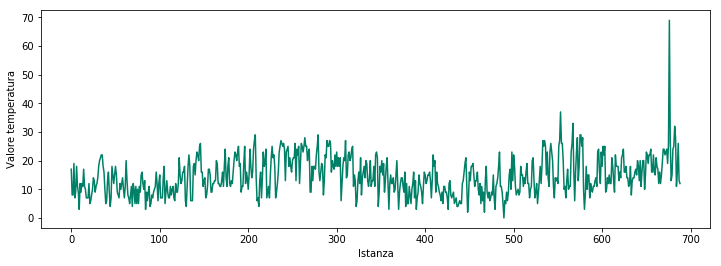

In [7]:
# Prendo la temperatura massima meno quella minima per calcolare l'escursione termica
dataset['Range_Temperatura'] = dataset['Max_Temperature_F'] - dataset['Min_TemperatureF']
dataset['Range_Temperatura'].plot(figsize = (12, 4), colormap = 'summer')
plt.xlabel('Istanza')
plt.ylabel('Valore temperatura')
plt.show()

### Punto 1.4

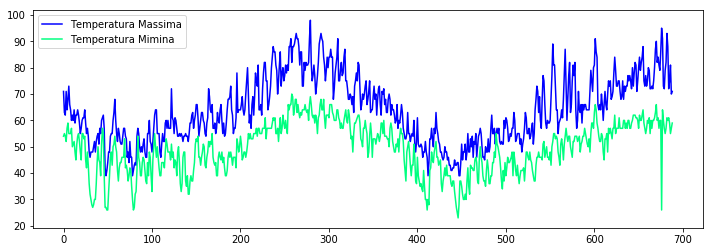

In [8]:
# Unisco prendo le due colonne e costruisco un nuovo dataFrame per poterlo visualizzare
df_temp = {'Temperatura Massima' : dataset['Max_Temperature_F'],
            'Temperatura Mimina' : dataset['Min_TemperatureF']}
max_min = pd.DataFrame(df_temp)
max_min.plot(figsize =(12, 4), colormap = 'winter')
plt.show()

### Punto 1.5

Il numero di eventi del 2015: 365


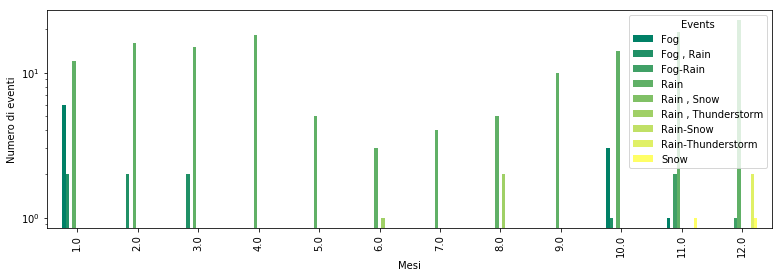

In [9]:
# Raggruppo gli eventi per anni
years = dataset.groupby('Year').size()
# Prendo il 2015
year2015 = years[2015]
print('Il numero di eventi del 2015:', year2015)

yme = dataset.groupby(['Year','Month','Events']).size().unstack()
yme_2015 = yme.loc[2015]
# Per visualizzare meglio trasformo l'asse y in logaritmi
yme_2015.plot(figsize = (13, 4), kind = 'bar', colormap = 'summer', logy = True)
plt.xlabel('Mesi')
plt.ylabel('Numero di eventi')
plt.show()

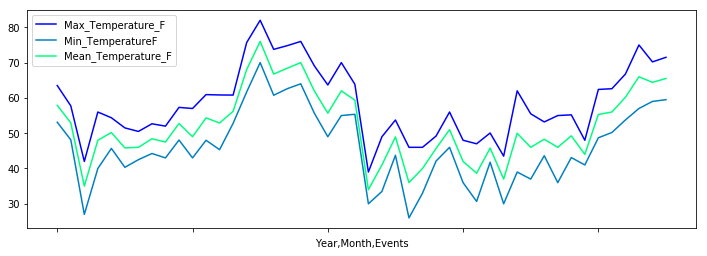

In [10]:
# Raggruppo per Anno, Mese ed evento e considero i valori di Temperatura
mean_temp = dataset.groupby(['Year', 'Month', 'Events'])['Max_Temperature_F',
                                                         'Min_TemperatureF','Mean_Temperature_F'].mean()
mean_temp.plot(figsize = (12, 4), colormap = 'winter')
plt.show()

In [11]:
#Pivot per mesi e anno
year_month = pd.pivot_table(mean_temp, values = ['Mean_Temperature_F'], index = ['Year', 'Month'],
                            columns='Events')
year_month

Mean_Temperature_F                                             \
Events                      Fog Fog , Rain Fog-Rain       Rain Rain , Snow   
Year   Month                                                                 
2014.0 10.0                 NaN        NaN      NaN  57.888889         NaN   
       11.0                 NaN        NaN      NaN  52.937500        35.0   
       12.0           48.000000        NaN      NaN  50.187500         NaN   
2015.0 1.0            45.833333       46.0      NaN  48.416667         NaN   
       2.0                  NaN       47.5      NaN  52.750000         NaN   
       3.0                  NaN       49.0      NaN  54.333333         NaN   
       4.0                  NaN        NaN      NaN  52.888889         NaN   
       5.0                  NaN        NaN      NaN  56.200000         NaN   
       6.0                  NaN        NaN      NaN  68.000000         NaN   
       7.0                  NaN        NaN      NaN  66.750000         NaN   
       8.0                  NaN        NaN      NaN  68.400000         NaN   
       9.0                  NaN        NaN      NaN  62.000000         NaN   
       10.0           55.666667       62.0      NaN  59.357143         NaN   
       11.0           34.000000        NaN     41.0  48.947368         NaN   
       12.0                 NaN        NaN     40.0  45.652174         NaN   
2016.0 1.0            38.666667        NaN      NaN  45.777778         NaN   
       2.0            50.000000        NaN     46.0  48.285714         NaN   
       3.0                  NaN        NaN     46.0  49.250000         NaN   
       4.0                  NaN        NaN      NaN  55.300000         NaN   
       5.0                  NaN        NaN      NaN  56.000000         NaN   
       6.0                  NaN        NaN      NaN  60.166667         NaN   
       7.0                  NaN        NaN      NaN  64.400000         NaN   
       8.0                  NaN        NaN      NaN  65.500000         NaN   

                                                                    
Events       Rain , Thunderstorm Rain-Snow Rain-Thunderstorm  Snow  
Year   Month                                                        
2014.0 10.0                  NaN       NaN               NaN   NaN  
       11.0                  NaN       NaN               NaN   NaN  
       12.0                  NaN       NaN               NaN   NaN  
2015.0 1.0                   NaN       NaN               NaN   NaN  
       2.0                   NaN       NaN               NaN   NaN  
       3.0                   NaN       NaN               NaN   NaN  
       4.0                   NaN       NaN               NaN   NaN  
       5.0                   NaN       NaN               NaN   NaN  
       6.0                  76.0       NaN               NaN   NaN  
       7.0                   NaN       NaN               NaN   NaN  
       8.0                  70.0       NaN               NaN   NaN  
       9.0                   NaN       NaN               NaN   NaN  
       10.0                  NaN       NaN               NaN   NaN  
       11.0                  NaN       NaN               NaN  36.0  
       12.0                  NaN       NaN              51.0  42.0  
2016.0 1.0                   NaN      37.0               NaN   NaN  
       2.0                   NaN       NaN               NaN   NaN  
       3.0                   NaN       NaN              44.0   NaN  
       4.0                   NaN       NaN               NaN   NaN  
       5.0                   NaN       NaN               NaN   NaN  
       6.0                   NaN       NaN              66.0   NaN  
       7.0                   NaN       NaN               NaN   NaN  
       8.0                   NaN       NaN               NaN   NaN

In [12]:
# Pivot per anno ed eventi
year_events = pd.pivot_table(mean_temp, values = ['Mean_Temperature_F'], index = ['Year', 'Events'],
                            columns='Month')
year_events

Mean_Temperature_F                        \
Month                                    1.0        2.0        3.0    
Year   Events                                                         
2014.0 Fog                                NaN        NaN        NaN   
       Rain                               NaN        NaN        NaN   
       Rain , Snow                        NaN        NaN        NaN   
2015.0 Fog                          45.833333        NaN        NaN   
       Fog , Rain                   46.000000  47.500000  49.000000   
       Fog-Rain                           NaN        NaN        NaN   
       Rain                         48.416667  52.750000  54.333333   
       Rain , Thunderstorm                NaN        NaN        NaN   
       Rain-Thunderstorm                  NaN        NaN        NaN   
       Snow                               NaN        NaN        NaN   
2016.0 Fog                          38.666667  50.000000        NaN   
       Fog-Rain                           NaN  46.000000  46.000000   
       Rain                         45.777778  48.285714  49.250000   
       Rain-Snow                    37.000000        NaN        NaN   
       Rain-Thunderstorm                  NaN        NaN  44.000000   

                                                                           \
Month                            4.0   5.0        6.0    7.0   8.0   9.0    
Year   Events                                                               
2014.0 Fog                        NaN   NaN        NaN    NaN   NaN   NaN   
       Rain                       NaN   NaN        NaN    NaN   NaN   NaN   
       Rain , Snow                NaN   NaN        NaN    NaN   NaN   NaN   
2015.0 Fog                        NaN   NaN        NaN    NaN   NaN   NaN   
       Fog , Rain                 NaN   NaN        NaN    NaN   NaN   NaN   
       Fog-Rain                   NaN   NaN        NaN    NaN   NaN   NaN   
       Rain                 52.888889  56.2  68.000000  66.75  68.4  62.0   
       Rain , Thunderstorm        NaN   NaN  76.000000    NaN  70.0   NaN   
       Rain-Thunderstorm          NaN   NaN        NaN    NaN   NaN   NaN   
       Snow                       NaN   NaN        NaN    NaN   NaN   NaN   
2016.0 Fog                        NaN   NaN        NaN    NaN   NaN   NaN   
       Fog-Rain                   NaN   NaN        NaN    NaN   NaN   NaN   
       Rain                 55.300000  56.0  60.166667  64.40  65.5   NaN   
       Rain-Snow                  NaN   NaN        NaN    NaN   NaN   NaN   
       Rain-Thunderstorm          NaN   NaN  66.000000    NaN   NaN   NaN   

                                                             
Month                            10.0       11.0       12.0  
Year   Events                                                
2014.0 Fog                        NaN        NaN  48.000000  
       Rain                 57.888889  52.937500  50.187500  
       Rain , Snow                NaN  35.000000        NaN  
2015.0 Fog                  55.666667  34.000000        NaN  
       Fog , Rain           62.000000        NaN        NaN  
       Fog-Rain                   NaN  41.000000  40.000000  
       Rain                 59.357143  48.947368  45.652174  
       Rain , Thunderstorm        NaN        NaN        NaN  
       Rain-Thunderstorm          NaN        NaN  51.000000  
       Snow                       NaN  36.000000  42.000000  
2016.0 Fog                        NaN        NaN        NaN  
       Fog-Rain                   NaN        NaN        NaN  
       Rain                       NaN        NaN        NaN  
       Rain-Snow                  NaN        NaN        NaN  
       Rain-Thunderstorm          NaN        NaN        NaN

In [13]:
# Pivot mesi ed eventi
month_events = pd.pivot_table(mean_temp, values = ['Mean_Temperature_F'], index = ['Month', 'Events'],
                            columns='Year')
month_events

Mean_Temperature_F                      
Year                                  2014.0     2015.0     2016.0
Month Events                                                      
1.0   Fog                                NaN  45.833333  38.666667
      Fog , Rain                         NaN  46.000000        NaN
      Rain                               NaN  48.416667  45.777778
      Rain-Snow                          NaN        NaN  37.000000
2.0   Fog                                NaN        NaN  50.000000
      Fog , Rain                         NaN  47.500000        NaN
      Fog-Rain                           NaN        NaN  46.000000
      Rain                               NaN  52.750000  48.285714
3.0   Fog , Rain                         NaN  49.000000        NaN
      Fog-Rain                           NaN        NaN  46.000000
      Rain                               NaN  54.333333  49.250000
      Rain-Thunderstorm                  NaN        NaN  44.000000
4.0   Rain                               NaN  52.888889  55.300000
5.0   Rain                               NaN  56.200000  56.000000
6.0   Rain                               NaN  68.000000  60.166667
      Rain , Thunderstorm                NaN  76.000000        NaN
      Rain-Thunderstorm                  NaN        NaN  66.000000
7.0   Rain                               NaN  66.750000  64.400000
8.0   Rain                               NaN  68.400000  65.500000
      Rain , Thunderstorm                NaN  70.000000        NaN
9.0   Rain                               NaN  62.000000        NaN
10.0  Fog                                NaN  55.666667        NaN
      Fog , Rain                         NaN  62.000000        NaN
      Rain                         57.888889  59.357143        NaN
11.0  Fog                                NaN  34.000000        NaN
      Fog-Rain                           NaN  41.000000        NaN
      Rain                         52.937500  48.947368        NaN
      Rain , Snow                  35.000000        NaN        NaN
      Snow                               NaN  36.000000        NaN
12.0  Fog                          48.000000        NaN        NaN
      Fog-Rain                           NaN  40.000000        NaN
      Rain                         50.187500  45.652174        NaN
      Rain-Thunderstorm                  NaN  51.000000        NaN
      Snow                               NaN  42.000000        NaN

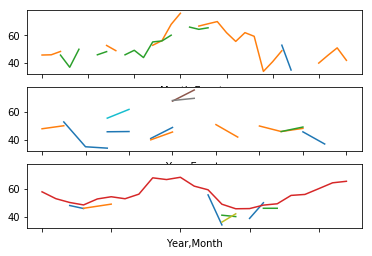

In [14]:
# Mostro le figure
fig, axes = plt.subplots(nrows = 3, ncols=1)
month_events.plot(ax = axes[0], legend=False)
year_events.plot(ax = axes[1], legend=False)
year_month.plot(ax = axes[2], legend=False)
plt.show()

### Punto 2.1

In [15]:
# Copio il DataFrame
df = dataset.copy()

# Trasformo i valori np.nan in zero
df.fillna(0, inplace=True)
# Prendo i valori diversi da zero e li trasformo tutti in uno. Indistintamente dal tipo
df['Events'] = np.where(df[['Events']] == 0, 0, 1)
# Conto i valori nel precedente dataset
valori_nan = dataset['Events'].isna().sum()
valori_notnan = dataset['Events'].notna().sum()

#Conto i valori nel nuovo dataset
valori_onezero = df['Events'].value_counts()
valori_one = valori_onezero[1]
valori_zero = valori_onezero[0]

# Print
print('Si può notare che i valori coincidono:')
print('Valori NaN {}, Valori non NaN {}'.format(valori_nan, valori_notnan))
print('Valori 0: {}, valori 1: {}'.format(valori_zero, valori_one))

Si può notare che i valori coincidono:
Valori NaN 361, Valori non NaN 328
Valori 0: 361, valori 1: 328


### Punto 2.2

In [16]:
X = df.drop('Events', axis = 1)
Y = df['Events']

# La colonna 'Date' mi crea problemi
label = LabelEncoder()
X['Date'] = X[['Date']].apply(label.fit_transform)

#Split
test_size = 0.33
random_state = 112
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = test_size, 
                                                    random_state = random_state)
# Fit e valutazione
bernoulli_NB = BernoulliNB()
bernoulli_NB.fit(X_train, Y_train)
score_BNB = bernoulli_NB.score(X_test, Y_test)
print('Accuracy Bernoulli NB: {:.03}'.format(score_BNB))

Accuracy Bernoulli NB: 0.57


### Punto 2.3

In [17]:
# Predict ed Accuracy Score
y_pred_BNB = bernoulli_NB.predict(X_test)
accuracy_BNB = accuracy_score(Y_test, y_pred_BNB)
print('Accuracy Bernoulli NB: {:.03}'.format(accuracy_BNB))

Accuracy Bernoulli NB: 0.57


### Punto 2.4

In [18]:
# Confusion Matrix
cm_BNB = confusion_matrix(Y_test, y_pred_BNB)
print('Confusion Matrix Bernoulli:\n', cm_BNB)

Confusion Matrix Bernoulli:
 [[118   1]
 [ 97  12]]


### Punto 2.5

In [19]:
# Ora alleno il Decision Tree
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
y_pred_DT = decision_tree.predict(X_test)
score_DT = decision_tree.score(X_test, Y_test)
cm_DT = confusion_matrix(Y_test, y_pred_DT)

print('Accuracy Decision Tree: {:.03}'.format(score_DT))
print('Confusion Matrix Decision Tree:\n', cm_DT)

Accuracy Decision Tree: 0.781
Confusion Matrix Decision Tree:
 [[91 28]
 [22 87]]


### Punto 2.6

In [20]:
# Creo una array di modelli
models = []
models.append(('LR', LogisticRegression()))
models.append(('DT', DecisionTreeClassifier()))
models.append((('ADAB', AdaBoostClassifier())))
models.append((('KNN', KNeighborsClassifier())))
models.append(('DT', DecisionTreeClassifier()))
models.append(('BNB', BernoulliNB()))

scores = []
names = []
seed = 10
scoring = 'accuracy'
for name, model in models:
    score = cross_val_score(model, X, Y, cv = seed, scoring = scoring)
    names.append(name)
    scores.append(score)
    print("{}: {:0.3f} ({:0.3f})".format(name, score.mean() * 100.0, score.std() * 100.0))

LR: 83.931 (8.144)
DT: 67.209 (9.454)
ADAB: 73.165 (11.770)
KNN: 45.590 (11.377)
DT: 67.952 (12.245)
BNB: 55.876 (3.386)


### Punto 2.7

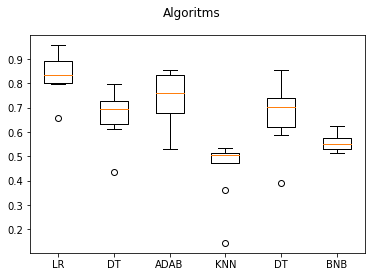

In [21]:
# Plot
fig = plt.figure()
fig.suptitle('Algoritms')
ax = fig.add_subplot(111)
plt.boxplot(scores)
ax.set_xticklabels(names)
plt.show()

### Punto 2.8

In [22]:
# Creo il DataFrame
reducer = pd.DataFrame()

values = [1, 2, 3, 4, 5, 6 ]
num = 6
for name in df.columns:
    if 'Mean' in name or 'mean' in name:
        try:
            prova = pd.qcut(df[name], q = num, labels= values)
            reducer = pd.concat([reducer, prova], axis = 1)
        except:
            print('Impossibile convertire: ', name)

X_train_red, X_test_red, Y_train_red, Y_test_red = train_test_split(reducer, Y, test_size = 0.25)

decision_tree.fit(X_train_red, Y_train_red)
score_red = decision_tree.score(X_test_red, Y_test_red)
print('Accuracy con Decision Tree e il DataFrame reduces: {:0.3f}'.format(score_red))

Impossibile convertire:  Mean_Visibility_Miles
Accuracy con Decision Tree e il DataFrame reduces: 0.792


### Punto 2.9

In [23]:
df = df.drop('Date', axis = 1)
train, test = train_test_split(df, test_size = 0.25)

dataset1 = train[train['Month'] < 5]
dataset2 = train[(train['Month'] > 4) & (train['Month'] < 9)]
dataset3 = train[train['Month'] > 9]

dataset1 = dataset1.drop('Month', axis = 1)
dataset2 = dataset2.drop('Month', axis = 1)
dataset3 = dataset3.drop('Month', axis = 1)

test = test.drop('Month', axis = 1)

from sklearn.ensemble import RandomForestClassifier
tree1 = RandomForestClassifier()
tree2 = RandomForestClassifier()
tree3 = RandomForestClassifier()

from sklearn.ensemble import VotingClassifier
voting = VotingClassifier(estimators=[('tree1', tree1), ('tree2', tree2), ('tree3', tree3)])
voting.fit(dataset1.drop('Events', axis = 1), dataset1['Events'])


VotingClassifier(estimators=[('tree1', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))],
         flatten_transform=None, n_jobs=1, voting='hard', weights=None)

### Punto 2.10

In [24]:
# Copio il DataFrame
dtz = dataset.copy()

# Prima modifico il dataset principale
# Innazitutto elimino i valori categorici
dtz['Date'] = dtz[['Date']].apply(label.fit_transform)
# Poi modifico la colonna da predirre
dtz['Events'].fillna(0, inplace = True)
dtz['Events'] = np.where(dtz['Events'] == 0 ,0 ,1)
dtz.dropna(axis = 1, inplace = True)

# Creo una colonna 'season' con le stagioni
values = [1, 2, 3, 4]
num = 4
dtz['Season'] = pd.qcut(dtz['Month'], q = num, labels = values)

# Normalizzo 

Xz = dtz.drop('Events', axis = 1)
Yz = dtz['Events']

# Rappoddio la dimensione
Xz = pd.concat([Xz, Xz])
Yz = pd.concat([Yz, Yz])

test_size = 0.33
random_state = 103
Xz_train, Xz_test, Yz_train, Yz_test = train_test_split(Xz, Yz, test_size = test_size, 
                                                        random_state = random_state)

decision_tree.fit(Xz_train, Yz_train)
scorez = decision_tree.score(Xz_test, Yz_test)
cm_z = confusion_matrix(Yz_test, decision_tree.predict(Xz_test))
print('Accuracy DECISIONE TREE e DATASET PERSONALIZZATO: {:0.3f}'.format(scorez))
print('Confusione matrix DECISIONE TREE e DATASET PERSONALIZZATO:\n{}'.format(cm_z))

Accuracy DECISIONE TREE e DATASET PERSONALIZZATO: 0.925
Confusione matrix DECISIONE TREE e DATASET PERSONALIZZATO:
[[220  14]
 [ 20 201]]
